# Mahcine Learning Project

Ruiyang Zhou 662005044

## 数据处理 Image Process

In [ ]:
import json
from PIL import Image, ImageDraw
import numpy as np
import os

# 假设你已经将标注文件上传到了Colab的默认工作目录
annotations_path = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/valid/_annotations.coco.json'  # 更新为你的标注文件名

# 假设你也将图片上传到了Colab的默认工作目录
images_dir = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/valid'  # Colab的默认工作目录

# 加载COCO格式的标注文件
with open(annotations_path, 'r') as f:
    coco_data = json.load(f)

for image_info in coco_data['images']:
    # 创建一个空白的蒙版图像，初始全部为0
    mask = Image.new('L', (image_info['width'], image_info['height']), 0)
    draw = ImageDraw.Draw(mask)

    # 找到所有对这张图片的标注
    image_annotations = [anno for anno in coco_data['annotations'] if anno['image_id'] == image_info['id']]

    for anno in image_annotations:
        # 如果有多边形分割信息，则使用它
        if 'segmentation' in anno:
            for segmentation in anno['segmentation']:
                # 绘制多边形，填充值为255
                draw.polygon(segmentation, outline=255, fill=255)

    # 构建图片路径
    image_path = os.path.join(images_dir, image_info['file_name'])

    # 尝试打开图片
    try:
        image = Image.open(image_path)
    except FileNotFoundError:
        print(f"文件未找到: {image_path}")
        continue

    # 保存或处理image和mask
    # 这里我们将蒙版保存到当前工作目录
    mask_save_path = os.path.join('/content/drive/MyDrive/sample/Floor Detection.v2i.coco', 'masks', image_info['file_name'].replace('.jpg', '_mask.png'))
    os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
    mask.save(mask_save_path)

    print(f"处理并保存了图片和蒙版：{image_info['file_name']}")



处理并保存了图片和蒙版：116_jpg.rf.014c9c003adfca53fb88754a84d26b84.jpg
处理并保存了图片和蒙版：24_jpg.rf.0865bb0b4df97844872730c1c99442e2.jpg
处理并保存了图片和蒙版：80_jpg.rf.028aa448dc38d78babfbae76cbeb2bf6.jpg
处理并保存了图片和蒙版：115_jpg.rf.07717d7833fc275df93f41559413be7c.jpg
处理并保存了图片和蒙版：156_jpg.rf.0e86154c20625ce36b47e766a0ffd888.jpg
处理并保存了图片和蒙版：30_jpg.rf.0b556dc11e12c130c353f58b0ba76be4.jpg
处理并保存了图片和蒙版：11_kitchen_jpg.rf.106f426be9a583106ca735110c8fee8b.jpg
处理并保存了图片和蒙版：62_jpg.rf.0b991a3c299290eb97568dd687b92f78.jpg
处理并保存了图片和蒙版：339_jpg.rf.11488067ff53d97b0aa2c447a7851030.jpg
处理并保存了图片和蒙版：12_bathroom_jpg.rf.1571e51a8a3ab262fe245aea716dfba0.jpg
处理并保存了图片和蒙版：125_jpg.rf.1219f6aa8a0e5c2da324b2fbf6b5dafb.jpg
处理并保存了图片和蒙版：5_bedroom_jpg.rf.10a9510a66b18ce3294d381db93cff21.jpg
处理并保存了图片和蒙版：156_jpg.rf.174abf8aa1fa5f3039e43822e876c76b.jpg
处理并保存了图片和蒙版：2_bedroom_jpg.rf.1ab683133f5f430bf7e71481b2d48119.jpg
处理并保存了图片和蒙版：71_jpg.rf.24fcb01c7950817365bd3a1ebd140588.jpg
处理并保存了图片和蒙版：50_jpg.rf.1d78cc378edb6df32d8b881dd30573e1.jpg
处理并保存了图片和蒙版：15_jpg.

## 图像预处理 Image Arrange

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image, ImageOps

def load_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    """
    加载并调整图像及其对应蒙版的大小，确保图像正确处理旋转，并归一化。
    """
    image = load_img(image_path)  # 使用Keras的load_img以更好地集成
    image = ImageOps.exif_transpose(image)  # 修正可能的旋转问题
    image = img_to_array(image.resize(target_size, Image.Resampling.LANCZOS)) / 255.0  # 归一化

    mask = load_img(mask_path, color_mode='grayscale')
    mask = img_to_array(mask.resize(target_size, Image.Resampling.NEAREST)) / 255.0
    mask = np.expand_dims(mask, axis=-1)  # 为蒙版增加一个通道维度

    return image, mask

def load_dataset(image_dir, mask_dir, target_size=(256, 256)):
    images, masks = [], []

    for filename in os.listdir(image_dir):
        # 跳过非图像文件
        if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename.replace(".jpg", "_mask.png"))  # 确保蒙版文件名匹配

        if not os.path.exists(mask_path):
            print(f"Mask file not found for {filename}, skipping.")
            continue

        image, mask = load_image_and_mask(image_path, mask_path, target_size)
        images.append(image)
        masks.append(mask[:,:,0])  # 确保蒙版是三维数组，而不是四维

    return np.array(images), np.array(masks)

# 对get_data_generators函数不需要改动，错误主要由数据加载部分引起


# 数据增强
def get_data_generators(X_train, Y_train, X_val, Y_val, batch_size=32):
    """
    创建并返回数据增强生成器。
    """
    data_gen_args = dict(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_datagen.fit(X_train, augment=True, seed=42)
    mask_datagen.fit(Y_train, augment=True, seed=42)

    image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(Y_train, batch_size=batch_size, seed=42)

    train_generator = zip(image_generator, mask_generator)

    # 验证集不使用数据增强
    val_generator = (X_val, Y_val)

    return train_generator, val_generator

# 路径配置和数据准备
image_dir = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/train'
mask_dir = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/masks_train'

try:
    X, Y = load_dataset(image_dir, mask_dir)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
    train_generator, val_generator = get_data_generators(X_train, Y_train, X_val, Y_val)
except FileNotFoundError as e:
    print(e)
    print("请检查您的文件路径是否正确，并确保所有文件都存在。")




## 模型训练 Model Training

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

def build_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # 编码器
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # 可以添加更多的编码器层...

    # 解码器
    # 可以添加更多的解码器层...
    up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(pool1)
    merge1 = concatenate([conv1, up1], axis=3)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)

    conv2 = Conv2D(1, 1, activation='sigmoid')(conv2)

    model = Model(inputs=inputs, outputs=conv2)

    return model



In [4]:
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [5]:
results = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,  # 根据你的数据量和批次大小进行调整
    validation_steps=50,  # 同上
    epochs=20  # 根据模型的实际表现进行调整
)



Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8425

100/100 [==============================] - 77s 579ms/step - loss: 0.4077 - accuracy: 0.8425 - val_loss: 0.4112 - val_accuracy: 0.8450
Epoch 2/20
100/100 [==============================] - 49s 491ms/step - loss: 0.3797 - accuracy: 0.8520
Epoch 3/20
100/100 [==============================] - 48s 480ms/step - loss: 0.3745 - accuracy: 0.8524
Epoch 4/20
100/100 [==============================] - 49s 489ms/step - loss: 0.3731 - accuracy: 0.8524
Epoch 5/20
100/100 [==============================] - 48s 484ms/step - loss: 0.3699 - accuracy: 0.8522
Epoch 6/20
100/100 [==============================] - 49s 486ms/step - loss: 0.3716 - accuracy: 0.8509
Epoch 7/20
100/100 [==============================] - 49s 489ms/step - loss: 0.3643 - accuracy: 0.8525
Epoch 8/20
100/100 [==============================] - 49s 487ms/step - loss: 0.3618 - accuracy: 0.8533
Epoch 9/20
100/100 [==============================] - 49s 488ms/step - loss: 0.3609 - accuracy: 0.8529
Epoch 10/20
100/100 [=====================

In [6]:
# 假设 X_test, Y_test 分别是你的图像和蒙版测试数据
test_loss, test_acc = model.evaluate(X, Y)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")



9/9 [==============================] - 3s 315ms/step - loss: 0.3158 - accuracy: 0.8648
Test loss: 0.31582218408584595, Test accuracy: 0.8647749423980713


In [7]:
# 假设 X_val, Y_val 分别是您的图像和蒙版验证数据
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")


2/2 [==============================] - 4s 4s/step - loss: 0.3593 - accuracy: 0.8447
Validation loss: 0.35934823751449585, Validation accuracy: 0.8446750044822693


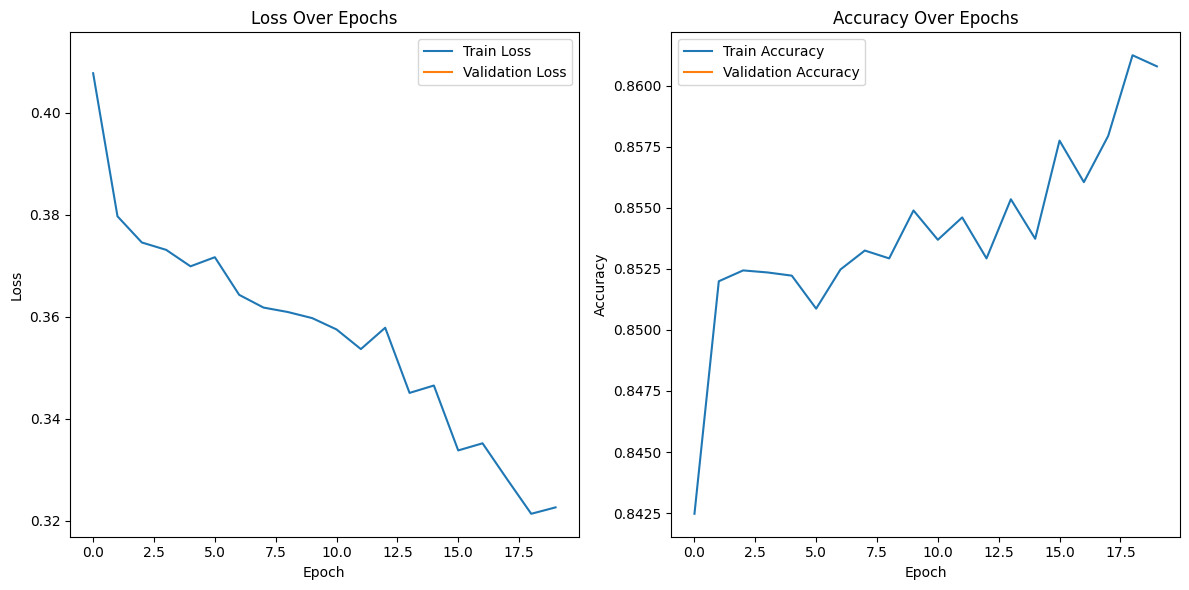

In [8]:
import matplotlib.pyplot as plt

# 假设results是model.fit()的返回值
history = results.history

# 绘制损失图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率图
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 测试 Test

1/1 [==============================] - 0s 20ms/step


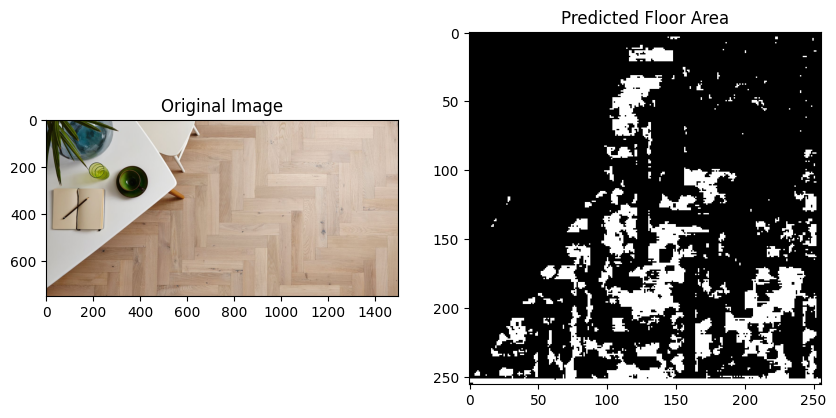

In [11]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from PIL import Image

# 加载图片
image_path = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/test3.jpg'  # 更新为您的图片路径
image = load_img(image_path, target_size=(256, 256))  # 假设您的模型接受256x256的图片
image = img_to_array(image)
image = np.expand_dims(image, axis=0)  # 增加一个维度以符合模型的输入要求
image /= 255.0  # 归一化到0-1之间

# 假设model是您训练好的模型
prediction = model.predict(image)

import matplotlib.pyplot as plt

# 将预测结果转换为二值化掩膜
predicted_mask = prediction[0]  # 假设只有一个预测结果
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # 使用0.5作为阈值进行二值化

# 展示原始图片
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(load_img(image_path))  # 直接加载原始大小的图片进行展示

# 展示预测的掩膜
plt.subplot(1, 2, 2)
plt.title("Predicted Floor Area")
plt.imshow(predicted_mask[:, :, 0], cmap='gray')  # 假设掩膜是单通道的

plt.show()
